<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span><ul class="toc-item"><li><span><a href="#Import-Stuff" data-toc-modified-id="Import-Stuff-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import Stuff</a></span></li><li><span><a href="#Some-Anonymous-Functions" data-toc-modified-id="Some-Anonymous-Functions-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Some Anonymous Functions</a></span></li><li><span><a href="#Named-Functions" data-toc-modified-id="Named-Functions-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Named Functions</a></span></li><li><span><a href="#Tidy-Data" data-toc-modified-id="Tidy-Data-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Tidy Data</a></span></li></ul></li><li><span><a href="#Dipole-Analysis" data-toc-modified-id="Dipole-Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dipole Analysis</a></span><ul class="toc-item"><li><span><a href="#By-Fill" data-toc-modified-id="By-Fill-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>By Fill</a></span></li><li><span><a href="#Average-Dipole-vs-Fill" data-toc-modified-id="Average-Dipole-vs-Fill-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Average Dipole vs Fill</a></span></li></ul></li></ul></div>

# Setup

## Import Stuff

In [1]:
import pickle as pkl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as GS
import numpy as np
import seaborn as sns
%matplotlib inline

sns.set()

try:
    with open("tidy_data/pc_vacuum_beryl_geometry.pkl","rb") as file_in:
        raw_data = pkl.load(file_in)
        print("Pickled data sucessfully loaded.")
        raw_df = pd.DataFrame(raw_data)
except:
    print("Error loading data.")
    
print("Extracting system info.")
infos = []
for idx,row in raw_df.iterrows():
    infos.append(row.sys_info)
    
info_df = pd.DataFrame(infos)
info_df.head()
raw_df = (pd.concat([raw_df,info_df],axis=1)
          .drop(["fpath","sys_info"],axis=1))
print("Done.")
raw_df.head()


Pickled data sucessfully loaded.
Extracting system info.
Done.


,dipoles,total_dipole,config,couple,fill,run
0,"[1.8353366732101177, 1.8331472552210455]",89.157334,58,antiferro,1010,23
1,"[1.8405237159534147, 1.8401578482689507]",89.156959,58,antiferro,1010,10
2,"[1.8397722976658348, 1.838676792848502]",267.473704,58,antiferro,1010,4
3,"[25.054070608125585, 1.8369967020530942]",92.814131,58,antiferro,1010,2
4,"[1.8395250818127546, 1.834044856130144]",89.157733,58,antiferro,1010,9


## Some Anonymous Functions

In [2]:
filter_by_fill = lambda fill,df: df[df.fill == fill]
filter_by_couple = (lambda couple,df: df[df.couple == couple]
                    .sort_values(["config","run"],axis=0))
                   # .set_index(["config"]))
filter_by_config = lambda config,df: df[df.config == config]
filter_by_type = lambda type_,df: df[df.type == type_]
flatten = lambda x: [j for i in x for j in i]
get_dipoles = lambda df: flatten(df.dipoles.values)
get_total_dipole = lambda df: df.total_dipole.values

drop_outliers = lambda df: df.drop(df.index[return_outliers(df.total_dipole)])

## Named Functions

In [3]:
def reject_outliers(data, m = 1.):
        '''Used modified Z-score itl.nist.gov/div898/handbook/eda/section3/eda35h.htm '''
        data = np.array(data)
        d = np.abs(data - np.median(data))
        mdev = np.median(d)
        s = d/mdev if mdev else 0.
        return data[s<m]
    
def return_outliers(data, m = 1.0):
    '''Used modified Z-score itl.nist.gov/div898/handbook/eda/section3/eda35h.htm '''
    data = np.array(data)
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    reject = list(data[s>=m])
    return [list(data).index(i) for i in reject]


def get_fill_df(couple,fill,m=1.0):   
    entries = []
    for config in list(set(raw_df.config.values)):
        
        try:
            df = filter_by_config(config,filter_by_couple(couple,filter_by_fill(fill,raw_df)))
            dipoles = get_dipoles(df)
            total_dipole = get_total_dipole(df)
            df = drop_outliers(df)
            clean_dipoles = get_dipoles(df)
            clean_total_dipole = get_total_dipole(df)

            entry = {'couple':couple, 'fill':fill, 'config':config, 
                     'raw_dipoles':dipoles,'clean_dipoles':clean_dipoles,
                     'raw_total_dipole':total_dipole,'clean_total_dipole':clean_total_dipole}

            entries.append(entry)
        except:
            print("Error: {} {} {} ".format(couple,fill,config))
        
    return pd.DataFrame(entries)



def make_dipole_plots(fill):
    df = filter_by_fill(fill,tidy_df)
    df_d = filter_by_type('dipole',df)
    df_td = filter_by_type('total_dipole',df)


    fig = plt.figure(figsize=(12,8))

    gs = GS.GridSpec(nrows=5,ncols=4,figure=fig,hspace=0.7)
    ax1 = plt.subplot(gs[:2,:2])
    ax2 = plt.subplot(gs[:2,2:])
    ax3 = plt.subplot(gs[2:,:])

    fig.suptitle("Dipole Analysis\nFill: {}".format(fill),fontsize=16)

    # Dipole by Configuratio
    for i in np.arange(60):
        config = filter_by_config(i,df_d)
        sns.kdeplot(config.value.values,ax=ax1)


    # Dipole and Total Dipole all Configurations

    if fill == 1000:
        sns.kdeplot(df_td.value.values,label="Total Dipole",ax=ax2)
        sns.kdeplot(df_d.value.values,label="Dipole",ax=ax2,shade=True)
    else:
        sns.kdeplot(df_d.value.values,ax=ax2,shade=True)


    # Barplot Dipole
    sns.barplot(x="config",y="value",data=df_d,ax=ax3)

    # Plot average on barplot
    ax3.axhline(df_d.value.mean(),ls="--",color="red")

    # Set axis limits based on barlot y-limits 
    lim = ax3.get_ylim()
    ax1.set(xlim=lim);
    ax2.set(xlim=lim);

    # Axis formatting
    ax1.set(xlabel="Dipole per Config [Debye]",ylabel="Density [a.u.]",yticklabels=[])
    ax2.set(xlabel="Dipole all Configs [Debye]",yticklabels=[])
    ax3.set(xlabel="Config",ylabel="Dipole [Debye]")
    _ = [l.set_visible(False) for (i,l) in enumerate(ax3.xaxis.get_ticklabels()) if i % 2 != 0]



## Tidy Data

In [4]:
fill_dfs = {}
for fill in [1000,1010,1100,1110,1111]:
    df = filter_by_fill(fill,raw_df).sort_values(["config","run"])
    fill_dfs[fill] = df
    for config in np.arange(60):
        config_df = filter_by_config(config,fill_dfs[fill])
        mask = return_outliers(config_df.total_dipole)
        rm = config_df.iloc[mask].index.values
        fill_dfs[fill].drop(rm,axis=0,inplace=True)


tidy_results = []

for key in fill_dfs.keys():
    df = fill_dfs[key]
    for idx,row in df.iterrows():
        couple = row['couple']
        config = int(row['config'])
        fill = int(row['fill'])
        run = int(row['run'])
        dipoles = row.dipoles
        total_dipole = row.total_dipole

        for d in dipoles:
            tidy = {'couple':couple,'config':config,'fill':fill,
                    'run':run,'type':'dipole','value':d}
            tidy_results.append(tidy)

        tidy = {'couple':couple,'config':config,'fill':fill,
                'run':run,'type':'total_dipole','value':total_dipole}

        tidy_results.append(tidy)

tidy_df = pd.DataFrame(tidy_results)
tidy_df.tail()

,config,couple,fill,run,type,value
12166,59,antiferro,1111,23,dipole,1.885116
12167,59,antiferro,1111,23,dipole,1.883228
12168,59,antiferro,1111,23,dipole,1.884747
12169,59,antiferro,1111,23,dipole,1.884065
12170,59,antiferro,1111,23,total_dipole,89.157334


# Dipole Analysis

## By Fill

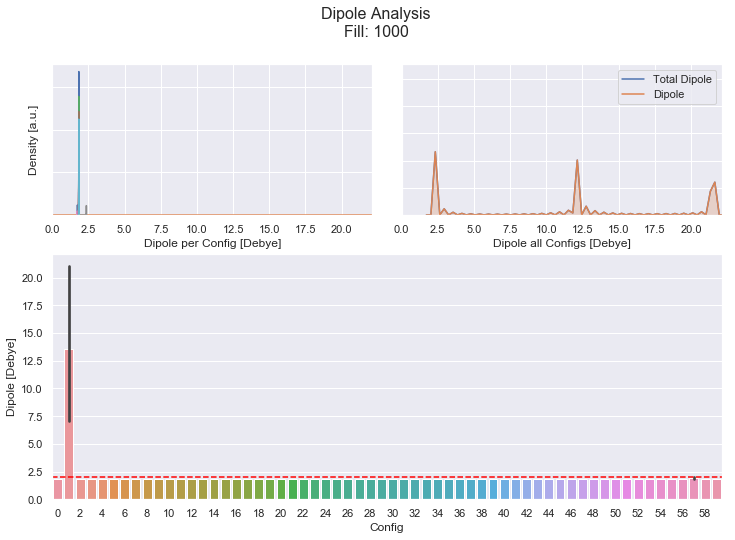

In [5]:
make_dipole_plots(1000)

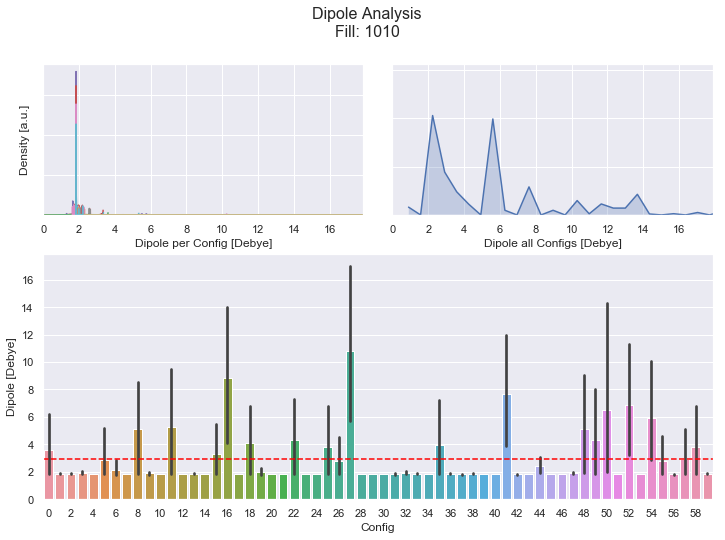

In [6]:
make_dipole_plots(1010)

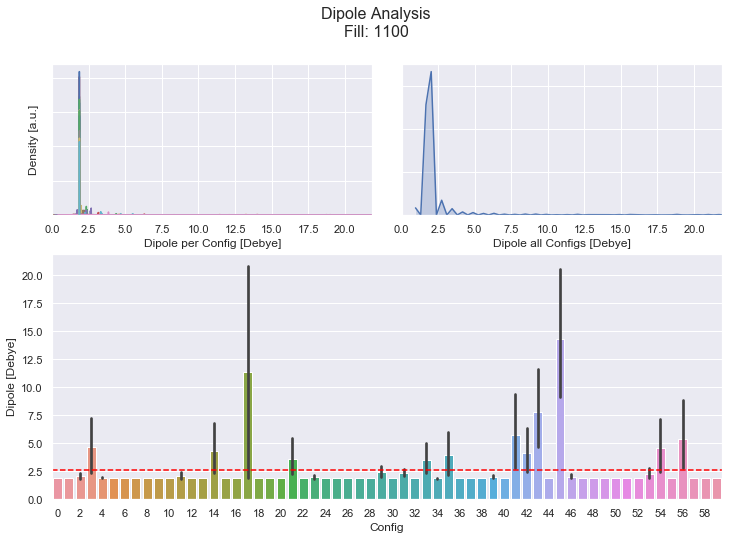

In [7]:
make_dipole_plots(1100)

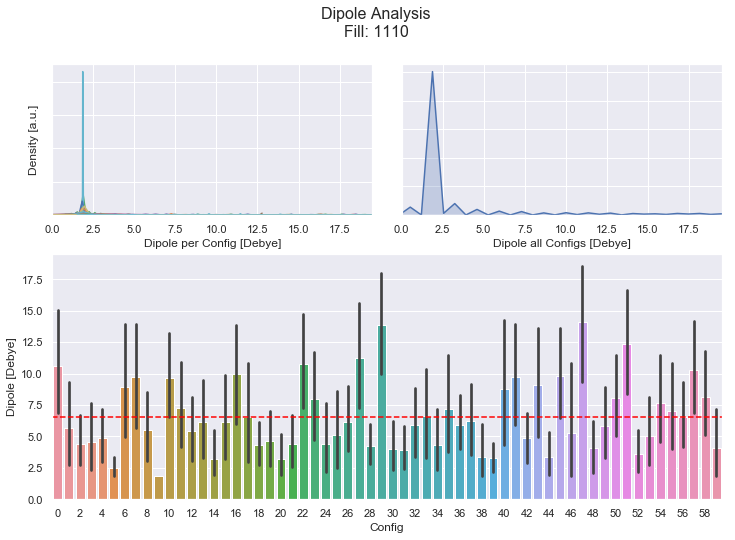

In [8]:
make_dipole_plots(1110)

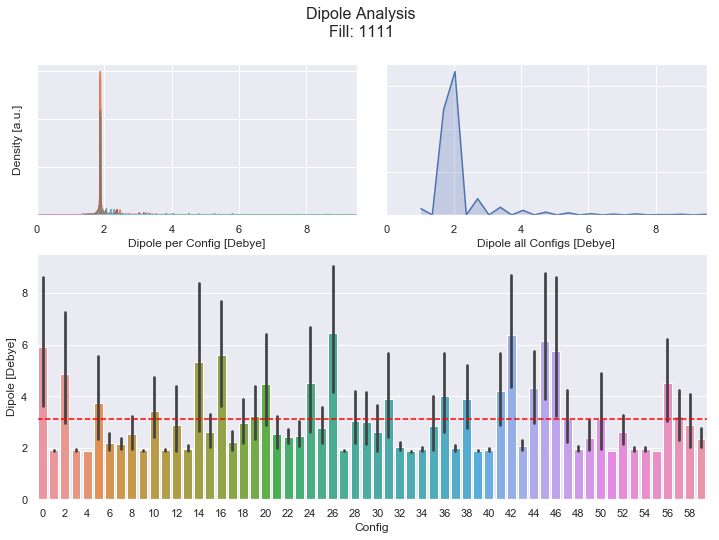

In [9]:
make_dipole_plots(1111)

## Average Dipole vs Fill

In [13]:
dipole_avgs = []
dipole_stds = []
fills = [25,50,50,75,100]

for fill in fill_dfs.keys():
    df = filter_by_fill(fill,tidy_df)
    df_d = filter_by_type('dipole',df)
    dipole_avgs.append(np.mean(df_d.value.values))
    dipole_stds.append(np.std(df_d.value.values)/np.sqrt(len(df_d.value.values)))


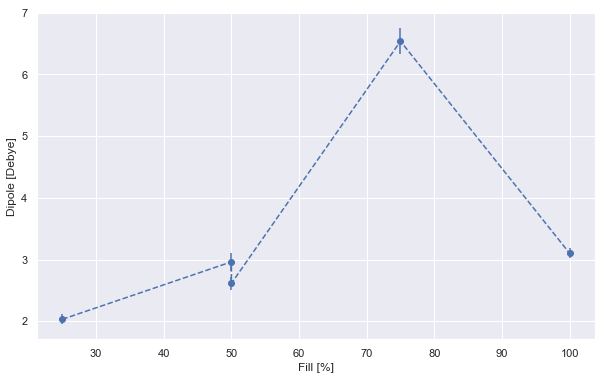

In [14]:
fig = plt.figure(figsize=(10,6))
ax = plt.gca()
plt.errorbar(fills,dipole_avgs,yerr=dipole_stds,fmt="--o");
ax.set(xlabel="Fill [%]",ylabel="Dipole [Debye]");
